This notebook is a summery of preprocessing and exploratory data analysis of two set of meRIP-Seq data from patient with COVID19. For each patient, we have sequence results for both input/IP for each sample. Here we use `exomePeak` for peak calling. To our experience, this is the only package comparing to other methods that supports samples from one conditions for the peak calling task; where other methods (like `RADAR`) require samples from two conditions to do both peak calling and differential analysis which is not our interest here.

Totally, there are 44 sequencing samples, 22 patients with both IN and RIP. 

Current pipeline contain these steps: 

#### Human genome 
1. Run `bcl2fastq` to make fastq files from raw data
        - input: bcl
        - output: fastq
2. Align to human genome using `STAR` and write unaligned reads in seprate `fastq` files
        - input: fastq
        - output1: bam
        - output2: fastq
3. Call human m6A peaks in each samples using `exomePeak` (see [here](https://bioconductor.riken.jp/packages/3.0/bioc/html/exomePeak.html)) and `gencode.v28.annotation`. 
        - input1: gtf
        - input2: bam
        - output: bed12

4. Taking bed12 results from step 3:
    1. Drawing meta-gene plot using `Guitar` (see [here](https://bioconductor.org/packages/3.11/bioc/html/Guitar.html)). 
    2. Using `cgat` (see [here](https://cgat.readthedocs.io/en/latest/cgat.html)) to prepare FIRE input. 
    2. Motif analysis using `FIRE`
    
Final results reported separately [here](https://github.com/goodarzilab/Abe/blob/master/Projects/COVID19_m6A/human-report.ipynb)

#### Virus genome 
5. Using `STAR` to build index and map COVID19 genome to unaligned reads to the human genome.
    According to Matt's epxeriance ([link](https://github.com/goodarzilab/khorms/blob/master/side_projects/COVID_DMSseq_library.ipynb)), I'm using [this genome annotation](https://www.ncbi.nlm.nih.gov/nuccore/MN908947?%3Fdb=nucleotide). 
        - input: fastq
            output2 of step 2. 
        - output: bam 


6. Using `exomePeak` with custom option that make it work for calling virus peaks. 
        - input1: gtf
        - input2: bam
        - output: bed12

7. Albertas is using m6A+ m6A- internal controls from [N6-Methyladenosine Enrichment Kit](https://international.neb.com/-/media/nebus/files/manuals/manuale1610.pdf?rev=c064d5e232414f709ef8bccee56f7687&hash=AAA94B8FDA043DD5A610E14686552B5E0209EA94). I'm using `bowtie2` to align reads in the `output2` from step 2. In a scatter plot, qPCR Ct for each patients is compered with number of virus m6A peaks.


8. Merge and intersect peaks found in all samples into a single `bed6` file and extract peak sequences. 
        - inputs: bed12
            outputs of step 6
        - output1: bed
        - output2: fasta

9. Count virus peaks as features using `bamToBed` plus `intersectBed` to count reads that aligned to each peaks. 
        - input1: bam 
            output of step 5.
        - input2: bed
            output1 of step 8. 
        - output: count-matrix 

        
10. Motif analysis using `regex` by extracting the sequence of each peaks and quary patterns
        - input: fasta
            output2 of step 8. 
        - output: motif-dataframe


11. Mutation analysis 


12. Implement R code from [here](https://github.com/lzcyzm/exomePeak/blob/master/R/ctest.R) for m6A vs. input test of significance. 


13. Heatmap data visualization

In [ ]:
!which python

In [45]:
!which python

/rumi/shams/abe/anaconda3/envs/fuzzy/bin/python


In [12]:
Samples = [
    "S0008","S0009","S0014","S0017","S0025",
    "S0026","S0030","S0042","S0057","S0085",
    "COV00075","COV00079","COV00084","COV00087","COV00093","COV00106",
    "COV00397","COV00413","COV00417","COV00419","COV00422","COV00432"    
]

In [17]:
renameSamples = [S.replace('S', 'COV0') for S in Samples]

(Some of below scripts repeated for both set of samples separately)

(I have used several separate conda environments for this analysis)

## 6. Virus peak calling 

I've played with `exomePeak` thresholds and we ended up using  ....

In [29]:
cat _sh/virus_peak.sh  

MAIN=/rumi/shams/abe/Projects/COVID19_m6A/
PEAKS=exomepeak/virus

cd $MAIN

for f in */bam/*_IN*.bam; do
	b=`basename $f`;
	b=${b/_IN.bam/};
	echo -------------------------$b------------------------
        Rscript _sh/exompeak.virus.R $MAIN $PEAKS $b _IN _RIP 0.025
	echo 'All done!'
done


In [30]:
cat _sh/exompeak.virus.R

args <- commandArgs(trailingOnly = TRUE)

print(args)
jobID  <- args[1]
OUTPUT <- args[2]
Sample <- args[3]
INPUT <- args[4]
IP <- args[5]
FDR <- args[6]

library(GenomicFeatures)
library(exomePeak)

GTF = '~/Projects/COVID19_m6A/virus/coronavirus_2_isolate_Wuhan-Hu-1.gff3'
######################################## read meta ######################################$
IP_BAM = paste(Sample, IP, '.bam', sep='')
INPUT_BAM = paste(Sample, INPUT, '.bam', sep='')

######################################## functions ######################################
txdb <- makeTxDbFromGFF(GTF, organism=NA )

setwd(jobID)
setwd("./virus_bam")

WINDOW = 50
STEP = 10
LENGTH = 200
ENRICH = 1
EXP = paste(Sample,'FDR', FDR,sep='_')

options(digits=5)
res <- exomepeak(
        TXDB = txdb,
        IP_BAM=IP_BAM,
        INPUT_BAM=INPUT_BAM,
        OUTPUT_DIR=paste('..',OUTPUT,sep='/'),
        EXPERIMENT_NAME=EXP,
        # options
        WINDOW_WIDTH = WINDOW,
        SLIDING_STEP = STEP,
        FRAGMENT_LENGTH

In [3]:
import igv
import os 

In [10]:
big_wigs = os.popen('ls virus_bw').read().split('\n')
# big_wigs

In [27]:
p_igv = igv.Browser(
    {"reference": {
        "id": "COVID",
        "fastaURL": "virus/coronavirus_2_isolate_Wuhan-Hu-1.fasta",
        "indexed":  "virus/coronavirus_2_isolate_Wuhan-Hu-1.fasta.fai",
        "tracks": [
            {
                "name": "MergedPeaks",
                "height": 300,
                "displayMode": "SQUISHED",
                "url": "merge_peaks.bed"
            }
        ]
    }}
)


In [35]:
def add_bam(b, bam, path_to_bam):
    b.load_track(
        {
            "name": bam,
            "url": path_to_bam,
            "indexURL": path_to_bam + ".bai",
            "format": "bam",
            "type": "alignment"
        })

In [28]:
p_igv.show()

In [32]:
p_igv.get_svg()

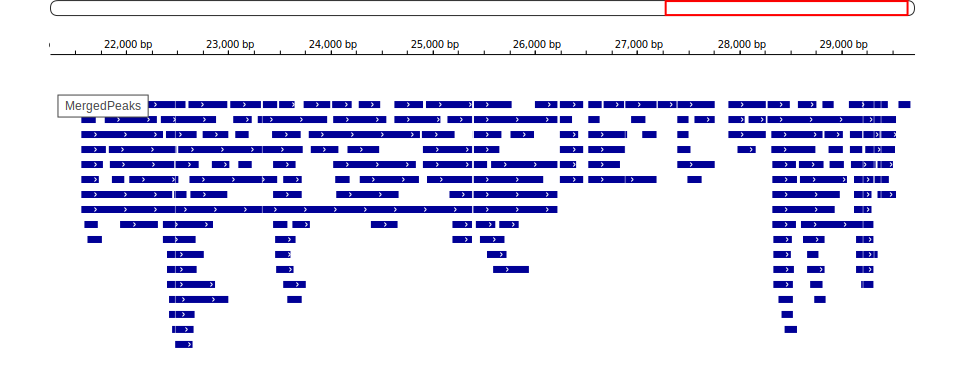

In [33]:
p_igv.display_svg()